In [2]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)
import time


In [3]:
# setup basic arguments for qed-ci calculation

# z-matrix for LIH
mol_str = """
Li
H 1 1.8
symmetry c1
"""

# options for Psi4
options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}

# options for the PFHamiltonian Generator class - include cavity effects
cavity_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.01]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 1, #<== this is a minimal photon basis, should explore increasing this 
}

# options for PFHamiltonian Generator class - exclude cavity effects
cavity_free_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}



In [7]:
# template for the z-matrix so we can scan through bond lengths
mol_tmpl = """
Li
H 1 **R**
symmetry c1
"""


# number of bondlengths in the scan
N_R = 50

# number of electronic states to save
N_el = 10

r_array = np.linspace(1.4, 2.2, N_R)

# array for energies for LiH outside cavity
cavity_free_E_array = np.zeros((N_R, N_el))

# array  for energies inside the cavity
cavity_E_array = np.zeros((N_R, N_el))

r_idx = 0
for r in r_array:
    mol_str = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(mol_str)
    print(mol_str)
    
    # call psi4 RHF
    scf_e, wfn = psi4.energy('SCF/sto-3g', return_wfn=True)
    
    # call psi4 FCI
    fci_energy = psi4.energy('fci/sto-3g',ref_wfn=wfn)
    
    # LiH no cavity
    LiH = PFHamiltonianGenerator(mol_str, options_dict, cavity_free_dict)

    # check to make sure PFHamiltonian cavity-free FCI ground-state agrees with psi4
    assert np.isclose(LiH.CIeigs[0], fci_energy)
    
    # LiH with cavity
    LiH_cav = PFHamiltonianGenerator(mol_str, options_dict, cavity_dict)
    cavity_free_E_array[r_idx,:] = LiH.CIeigs[:N_el]
    cavity_E_array[r_idx,:] = LiH_cav.CIeigs[:N_el]
    r_idx += 1





Li
H 1 1.4
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.6946346236296055
CQED-RHF One-electron energy      = -12.6946346236296055
Nuclear repulsion energy          = 1.1339511657214287
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8605386610570473   dE = -7.86054E+00   dRMS = 1.78646E-13
SCF Iteration   2: Energy = -7.8605386610570420   dE =  5.32907E-15   dRMS = 3.97604E-14
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.86053866 hartree
Psi4  SCF energy: -7.86053866 hartree
 Completed QED-RHF in 0.08744597434997559 seconds
 Completed 1HSO Build in 5.412101745605469e-05 seconds
 Completed ERI Build in 0.0012259483337402344 seconds 
 Completed 2D build in 0.00021505355834960938 seconds
 Completed 1G build in 1.5974044799804688e-05 seconds
 Completed the Dipole Matrix Build in 3.695487976074219e-05 seconds
 Completed determinant list in 0.000453948974609375 seconds 
 Completed constant offset ma

In [14]:
from matplotlib import pyplot as plt

First plot the ground-state potential energy surfaces for LiH inside and outisde the cavity.  The effect of the cavity will raise the energy slightly.

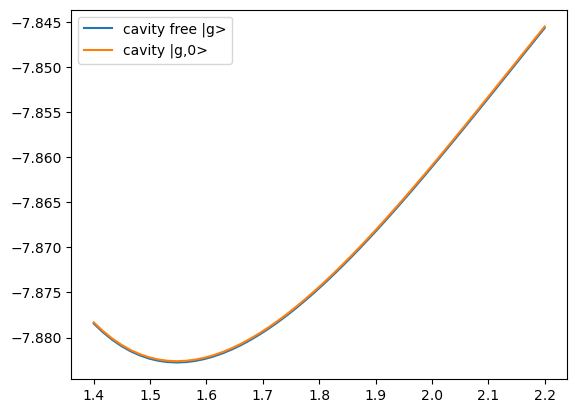

In [16]:
plt.plot(r_array, cavity_free_E_array[:,0], label='cavity free |g>')
plt.plot(r_array, cavity_E_array[:,0], label='cavity |g,0>')
plt.legend()
plt.show()


Next plot the ground state surface shifted by the cavity energy and the first excited state surface of 
LiH outside the cavity along with the lower- and upper-polariton surfaces from LiH inside the cavity.
Note that lower polariton surface intersects with another surface for the molecule in the cavity (see the crossing of the red and green curves around r = 1.5 Angstroms); the polariton surface is smooth, so we should really re-sort the eigenvalues around this point. Ruby has some experience doing this. 

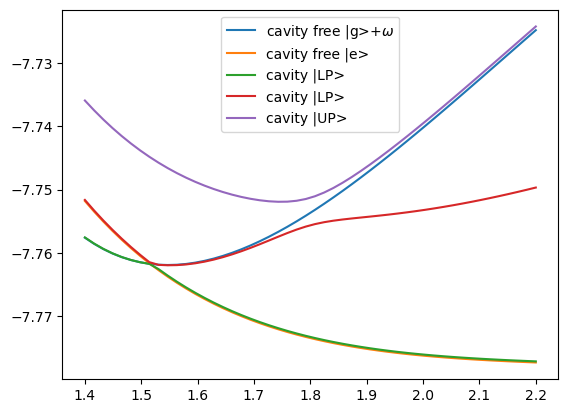

In [17]:
plt.plot(r_array, cavity_free_E_array[:,0]+0.12086, label='cavity free |g>+$\omega$')
plt.plot(r_array, cavity_free_E_array[:,1], label='cavity free |e>')
plt.plot(r_array, cavity_E_array[:,1], label='cavity |LP>')
plt.plot(r_array, cavity_E_array[:,2], label='cavity |LP>')
plt.plot(r_array, cavity_E_array[:,3], label='cavity |UP>')
plt.legend()
plt.show()